<a id='start'></a>
# Esercizi Lezione 5 - Reti neurali con Tensor Flow

In questo notebook vengono presentati degli esercizi sulle reti neurali con Tensor Flow.

Provate a svolgere il seguente esercizio:<br>
1) [pp -> H -> ZZ -> 4lepton](#section1)<br>
2) [Classificare i getti di particelle](#section2)<br>

<a id='section1'></a>
## pp -> H -> ZZ -> 4lepton

Creare una rete neurale per analizzare i dati prodotti dagli studi di pp -> H -> ZZ -> 4lepton nel contesto delle ricerche mono-Higgs da parte della collaborazione CMS. I programmi usano le ntuple ridotte (con il nome dell'albero radice HZZ4LeptonsAnalysisReduced) create con Root.

In [1]:
import uproot
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'

VARS = ['f_mass4l', 'f_massjj']
upfile_VV = uproot.open('data/ntuple_4mu_VV.root')
params_VV = upfile_VV[treename].arrays(VARS, library="np")
upfile_BKG = uproot.open('data/ntuple_4mu_bkg.root')
params_BKG = upfile_BKG[treename].arrays(VARS, library="np")

df_VV = pd.DataFrame(params_VV, columns=VARS)
df_BKG = pd.DataFrame(params_BKG, columns=VARS)
    
# cut out undefined variables VARS[0] and VARS[1] > -999
df_VV = df_VV[(df_VV[VARS[0]] > -999) & (df_VV[VARS[1]] > -999)]
df_BKG = df_BKG[(df_BKG[VARS[0]] > -999) & (df_BKG[VARS[1]] > -999)] 

# add isSignal variable
df_VV['isSignal'] = np.ones(len(df_VV)) 
df_BKG['isSignal'] = np.zeros(len(df_BKG))

df_all = pd.concat([df_VV, df_BKG])
df_all

,f_mass4l,f_massjj,isSignal
0,125.077103,1300.426880,1.0
1,124.238113,437.221863,1.0
3,124.480667,1021.744080,1.0
4,124.919464,1101.381958,1.0
7,125.049065,498.717194,1.0
...,...,...,...
58056,197.383133,114.257278,0.0
58057,218.065582,106.195534,0.0
58060,89.288086,53.661579,0.0
58062,146.756577,71.162025,0.0


Creiamo una rete densa, con un singolo livello nascosto completamente connesso con lo stesso numero di neuroni delle variabili di input.

Possiamo quindi usare la funzione di attivazione `sigmoide` per produrre un'uscita di probabilità nell'intervallo da 0 a 1.

Infine usiamo la funzione di loss `binary_crossentropy` durante l'allenamento, una funzione di perdita standard per problemi di classificazione binaria.

Infine utimmizziamo il modello con l'algoritmo Adam per il grandient descend.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU

NDIM = len(VARS)
model = Sequential()

model.add(Dense(2, input_dim=2))
model.add(ReLU())
model.add(Dense(units=2))
model.add(ReLU())
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
model.summary()

2023-05-23 09:22:30.419998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 re_lu (ReLU)                (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 re_lu_1 (ReLU)              (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [3]:
X = df_all[VARS]
y = df_all['isSignal']
X

,f_mass4l,f_massjj
0,125.077103,1300.426880
1,124.238113,437.221863
3,124.480667,1021.744080
4,124.919464,1101.381958
7,125.049065,498.717194
...,...,...
58056,197.383133,114.257278
58057,218.065582,106.195534
58060,89.288086,53.661579
58062,146.756577,71.162025


Procediamo a questo punto a suddividere i dati tra input e test e a effettuare uno scaling:

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
X_train_val = scaler.transform(x_train)
X_test_val = scaler.transform(x_test)

Ora facciamo il training:

Proviamo a fare una rete con una topologia differente, con 2 percettroni di uscita:

In [11]:
model2 = Sequential()

model2.add(Dense(2, input_dim=2))
model2.add(ReLU())
model2.add(Dense(units=2))
model2.add(ReLU())
model2.add(Dense(units=2, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 re_lu_4 (ReLU)              (None, 2)                 0         
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
 re_lu_5 (ReLU)              (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 2)                 6         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [12]:
# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model2.fit(X_train_val,
                    y_train,
                    epochs=1000, 
                    verbose=1, # switch to 0 for less verbosity 
                    callbacks=[early_stopping], 
                    validation_data=(X_test_val, y_test))

Epoch 1/1000
519/519 [==============================] - 3s 4ms/step - loss: 0.4444 - accuracy: 0.8873 - val_loss: 0.2618 - val_accuracy: 0.9417
Epoch 2/1000
519/519 [==============================] - 2s 3ms/step - loss: 0.2048 - accuracy: 0.9488 - val_loss: 0.1810 - val_accuracy: 0.9474
Epoch 3/1000
519/519 [==============================] - 2s 3ms/step - loss: 0.1621 - accuracy: 0.9531 - val_loss: 0.1528 - val_accuracy: 0.9503
Epoch 4/1000
519/519 [==============================] - 2s 3ms/step - loss: 0.1392 - accuracy: 0.9547 - val_loss: 0.1352 - val_accuracy: 0.9532
Epoch 5/1000
519/519 [==============================] - 2s 3ms/step - loss: 0.1260 - accuracy: 0.9562 - val_loss: 0.1221 - val_accuracy: 0.9544
Epoch 6/1000
519/519 [==============================] - 2s 3ms/step - loss: 0.1149 - accuracy: 0.9569 - val_loss: 0.1098 - val_accuracy: 0.9544
Epoch 7/1000
519/519 [==============================] - 2s 3ms/step - loss: 0.1040 - accuracy: 0.9574 - val_loss: 0.0979 - val_accuracy:

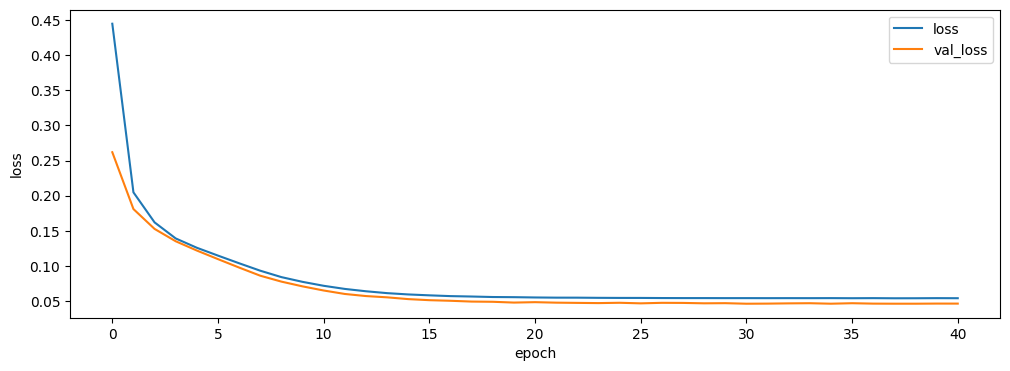

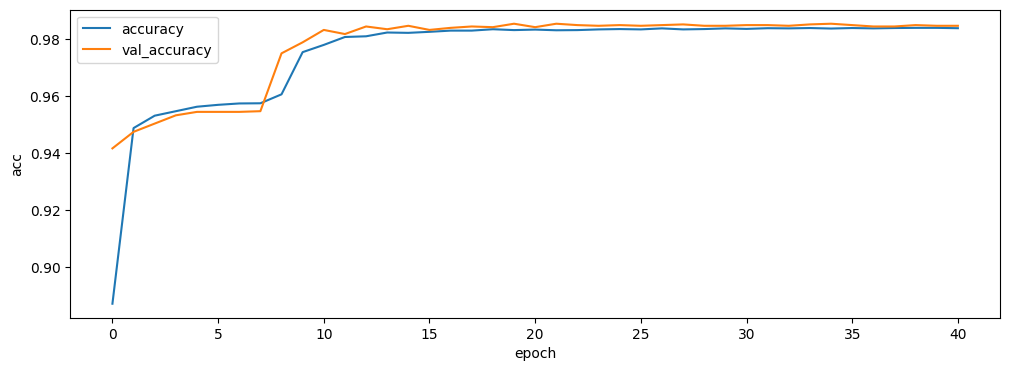

In [13]:
import matplotlib.pyplot as plt

# plot loss vs epoch
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# plot accuracy vs epoch
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [14]:
X_val = scaler.transform(X)
df_all['predict'] = 1 - model2.predict(X_val)

df_all['predict'] = np.around(df_all['predict']).astype(np.int64)
df_all['isSignal'] = np.around(df_all['isSignal']).astype(np.int64)

df_all

,f_mass4l,f_massjj,isSignal,predict
0,125.077103,1300.426880,1,1
1,124.238113,437.221863,1,1
3,124.480667,1021.744080,1,1
4,124.919464,1101.381958,1,1
7,125.049065,498.717194,1,1
...,...,...,...,...
58056,197.383133,114.257278,0,0
58057,218.065582,106.195534,0,0
58060,89.288086,53.661579,0,0
58062,146.756577,71.162025,0,0


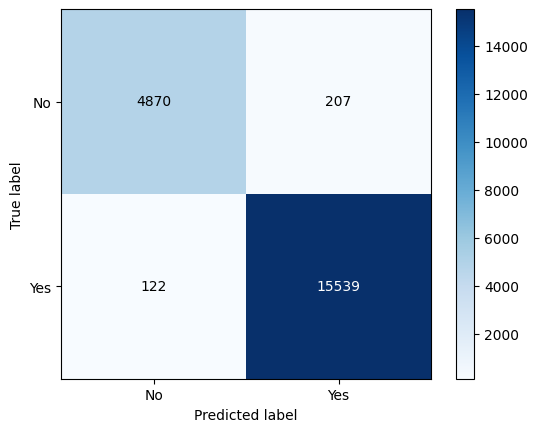

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_all['isSignal'].array, df_all['predict'].array)
classes = ['No', 'Yes']

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues)

ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

In [16]:
right = df_all.loc[df_all['predict'] == df_all['isSignal']]
wrong = df_all.loc[df_all['predict'] != df_all['isSignal']]

true_positive = right.loc[right['predict'] == 1]
false_positive = wrong.loc[wrong['predict'] == 1]
false_negative = wrong.loc[wrong['predict'] == 0]

print("We had %d elements in our recordset." % len(df_all))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 20738 elements in our recordset.
We classified correctly 20409 events.
We classified wrongly 329 events.
We had 207 false positive and 122 false negative.

Our precision has been 0.99.
Our recall has been 0.99.


<img src="img/Precisionrecall.png" width="300"/>

#### PyTorch
Proviamo a risolvere lo stesso problema con pyTorch.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#build model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=2)
        self.fc2 = nn.Linear(in_features=2, out_features=2)
        self.output = nn.Linear(in_features=2, out_features=2)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.output(x))
        return x
        
net = Net()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=2, bias=True)
)


In [6]:
X_train_val = torch.FloatTensor(X_train_val)
X_test_val = torch.FloatTensor(X_test_val)
y_train = torch.FloatTensor(y_train.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if abs(validation_loss - self.min_validation_loss) < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.counter = 0
        
        self.min_validation_loss = min(self.min_validation_loss, validation_loss)
        return False
    

# train the network
num_epoch = 100
history = { 'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': [] }
early_stopper = EarlyStopper(patience=10)

for epoch in range(num_epoch):
    # Facciamo apprendimento sul training e valutiamo i risultati sul test senza applicare
    # backpropagation e quindi senza fare ulteriore apprendimento.
    y_hat = net.forward(X_train_val)
    with torch.no_grad():
        y_test_hat = net.forward(X_test_val)
    
    # Calcoliamo loss e accuracy sul training
    loss = criterion(y_hat, y_train.long())
    y_out = torch.FloatTensor([z.tolist().index(max(z)) for z in y_hat])
    acc = torch.sum(y_out == y_train).double() / len(y_train)
    
    # Calcoliamo loss e accuracy sul test
    val_loss = criterion(y_test_hat, y_test.long())
    y_test_out = torch.FloatTensor([z.tolist().index(max(z)) for z in y_test_hat])
    val_acc = torch.sum(y_test_out == y_test).double() / len(y_test)
    
    # Storicizziamo i valori nella variabile history per plottare i grafici successivamente
    history['loss'].append(loss.detach().numpy().item())
    history['accuracy'].append(acc.detach().numpy().item())
    history['val_loss'].append(val_loss.detach().numpy().item())
    history['val_accuracy'].append(val_acc.detach().numpy().item())
 
    # Diamo un output sull'avazamento a console
    print('Epoch: %d - loss: %1.4f - accuracy: %1.4f - val_loss: %1.4f - val_accuracy: %1.4f' % (epoch, loss, acc, val_loss, val_acc))
 
    # Ottimizziamo l'apprendiamento
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if early_stopper.early_stop(val_loss):             
        print("Early stopping at epoch:", epoch)
        break

/tmp/ipykernel_1384/3976825636.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


Epoch: 0 - loss: 0.6042 - accuracy: 0.7561 - val_loss: 0.6059 - val_accuracy: 0.7517
Epoch: 1 - loss: 0.6025 - accuracy: 0.7561 - val_loss: 0.6043 - val_accuracy: 0.7517
Epoch: 2 - loss: 0.6010 - accuracy: 0.7561 - val_loss: 0.6028 - val_accuracy: 0.7517
Epoch: 3 - loss: 0.5995 - accuracy: 0.7561 - val_loss: 0.6013 - val_accuracy: 0.7517
Epoch: 4 - loss: 0.5980 - accuracy: 0.7561 - val_loss: 0.5999 - val_accuracy: 0.7517
Epoch: 5 - loss: 0.5966 - accuracy: 0.7561 - val_loss: 0.5985 - val_accuracy: 0.7517
Epoch: 6 - loss: 0.5952 - accuracy: 0.7561 - val_loss: 0.5972 - val_accuracy: 0.7517
Epoch: 7 - loss: 0.5939 - accuracy: 0.7561 - val_loss: 0.5959 - val_accuracy: 0.7517
Epoch: 8 - loss: 0.5926 - accuracy: 0.7561 - val_loss: 0.5946 - val_accuracy: 0.7517
Epoch: 9 - loss: 0.5913 - accuracy: 0.7561 - val_loss: 0.5933 - val_accuracy: 0.7517
Epoch: 10 - loss: 0.5901 - accuracy: 0.7561 - val_loss: 0.5921 - val_accuracy: 0.7517
Epoch: 11 - loss: 0.5888 - accuracy: 0.7561 - val_loss: 0.5909 -

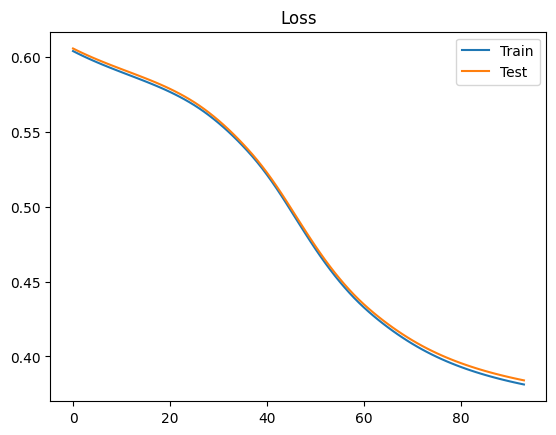

In [10]:
import matplotlib.pyplot as plt



plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Test'])
plt.show()

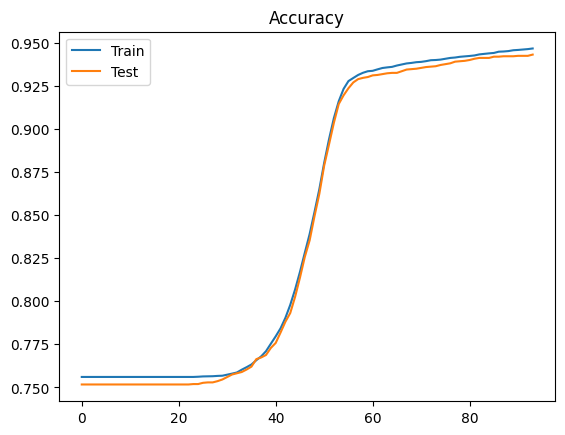

In [11]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Test'])
plt.show()

In [12]:
from sklearn.metrics import accuracy_score

preds = []
with torch.no_grad():
    for val in X_test_val:
        y_hat = net.forward(val)
        preds.append(y_hat.argmax().item())

acc = accuracy_score(y_test, preds)
print("Accuracy: %.2f" % acc)

/tmp/ipykernel_1384/3976825636.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


Accuracy: 0.94


/tmp/ipykernel_1384/3976825636.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


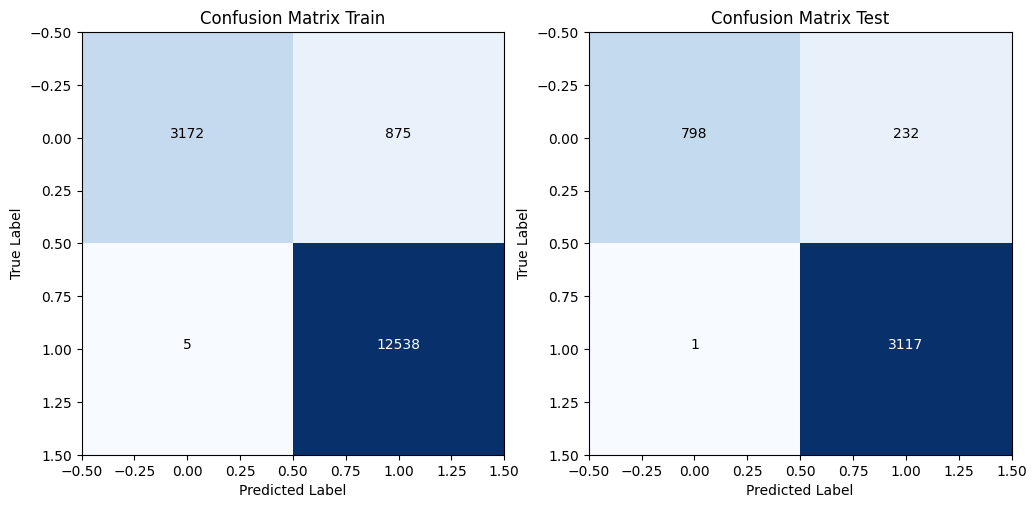

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

with torch.no_grad():
    y_train_hat = [np.argmax(v) for v in net.forward(X_train_val)]
    y_test_hat = [np.argmax(v) for v in net.forward(X_test_val)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cf = confusion_matrix(y_train, y_train_hat)
ax1.imshow(cf, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax1.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

cf = confusion_matrix(y_test, y_test_hat)
ax2.imshow(cf, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax2.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

plt.show()

<a id='section2'></a>
## Classificare i getti di particelle

Caricare i dati da `jetImage.h5` e quindi definizimo una DNN con tre livelli che, una volta allenata, aiuti a classificare i getti di particelle contenuti in jets.

Le ultime 6 feature (**'j_g' 'j_q' 'j_w' 'j_z' 'j_t' 'j_undef'**) riportano l'informazione di quale jet stiamo osservando. Le informazioni sono fornite con una codifica one-hot: tutti i flag sono 0 tranne quello per la categoria corretta, che è impostato su 1.

Ad esempio, un **W-jet** avrà indici **[0,0,1,0,0,0]**

Si noti che l'ultimo flag (**undefined**) viene utilizzato per jet di categorie diverse dalle cinque specificate. Poiché il nostro set di dati ha solo getti di questi cinque tipi, questo flag è sempre impostato su 0 e può essere scartato.

In [1]:
import h5py
import numpy as np

f = h5py.File("data/jetImage.h5")
jets = f.get('jets')
y = np.array(jets[:,-6:-1])
X = np.array(jets[:,:-6])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(63985, 53) (31515, 53) (63985, 5) (31515, 5)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

batch_size = 128
n_epochs = 500
dropoutRate = 0.25

# Create the model
model = Sequential()
model.add(BatchNormalization(input_shape=(53,)))
model.add(Dense(30, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(20, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(10, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

# print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 53)               212       
 ormalization)                                                   
                                                                 
 dense_9 (Dense)             (None, 30)                1620      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_10 (Dense)            (None, 20)                620       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                210       
                                                      

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

# Train the model
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=2,
            validation_data=(X_test, y_test),
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/500
500/500 - 9s - loss: 1.2293 - val_loss: 0.9037 - lr: 0.0010 - 9s/epoch - 18ms/step
Epoch 2/500
500/500 - 7s - loss: 1.0039 - val_loss: 0.7900 - lr: 0.0010 - 7s/epoch - 14ms/step
Epoch 3/500
500/500 - 7s - loss: 0.9366 - val_loss: 0.7101 - lr: 0.0010 - 7s/epoch - 14ms/step
Epoch 4/500
500/500 - 7s - loss: 0.9033 - val_loss: 0.6871 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 5/500
500/500 - 7s - loss: 0.8784 - val_loss: 0.6603 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 6/500
500/500 - 7s - loss: 0.8581 - val_loss: 0.6480 - lr: 0.0010 - 7s/epoch - 14ms/step
Epoch 7/500
500/500 - 7s - loss: 0.8480 - val_loss: 0.6380 - lr: 0.0010 - 7s/epoch - 14ms/step
Epoch 8/500
500/500 - 7s - loss: 0.8374 - val_loss: 0.6379 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 9/500
500/500 - 7s - loss: 0.8309 - val_loss: 0.6327 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 10/500
500/500 - 7s - loss: 0.8294 - val_loss: 0.6243 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 11/500
500/500 - 7s - loss: 0.8212 - val_lo

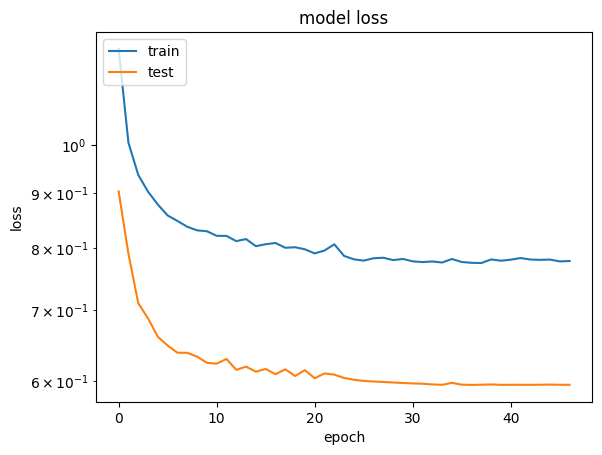

In [21]:
import matplotlib.pyplot as plt

# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

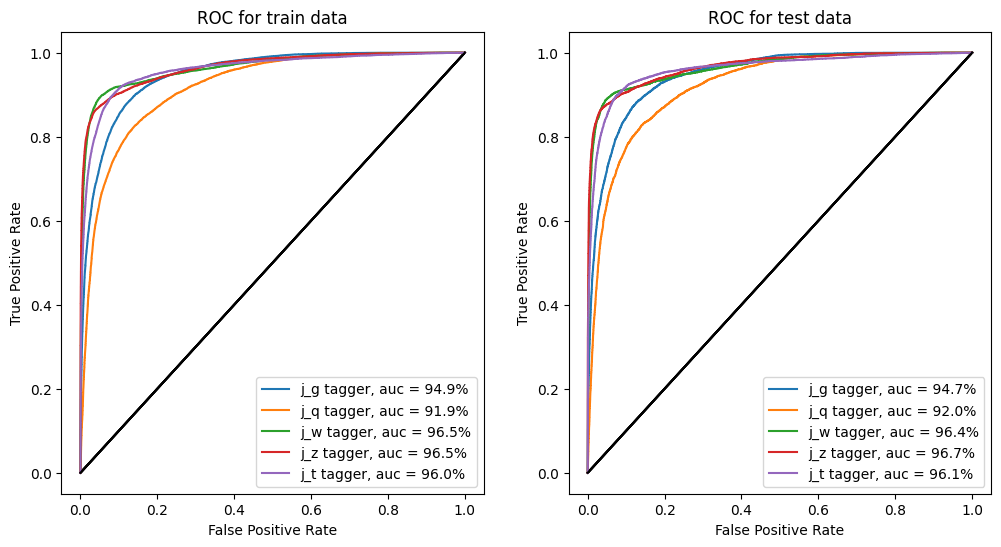

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']
fpr, tpr, auc1 = {}, {}, {}

y_test_proba = model.predict(X_test)
y_train_proba =  model.predict(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, label in enumerate(labels):
    df_label = y_train[:,i]
    df_label_pred = y_train_proba[:,i]
        
    fpr[label], tpr[label], _ = roc_curve(df_label, df_label_pred)
    auc1[label] = auc(fpr[label], tpr[label])

    ax1.plot(fpr[label], tpr[label], label='%s tagger, auc = %.1f%%' % (label, auc1[label]*100.))
    ax1.plot([0, 1], [0, 1], color='black')
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("ROC for train data")
    ax1.legend(loc="lower right")
    
for i, label in enumerate(labels):
    df_label = y_test[:,i]
    df_label_pred = y_test_proba[:,i]
        
    fpr[label], tpr[label], _ = roc_curve(df_label, df_label_pred)
    auc1[label] = auc(fpr[label], tpr[label])

    ax2.plot(fpr[label], tpr[label], label='%s tagger, auc = %.1f%%' % (label, auc1[label]*100.))
    ax2.plot([0, 1], [0, 1], color='black')
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC for test data")
    ax2.legend(loc="lower right")

plt.show()

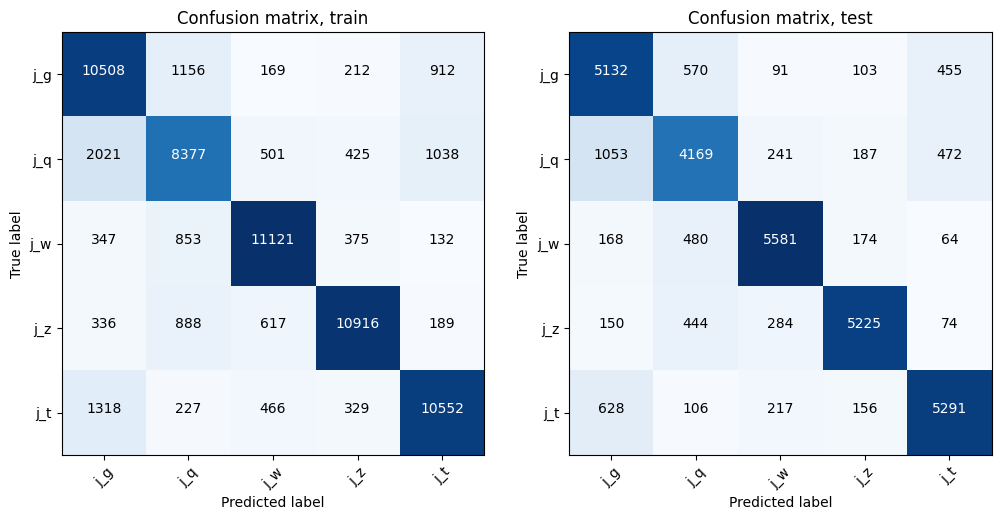

In [31]:
import itertools
from sklearn.metrics import confusion_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cnf_matrix_train = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(y_train_proba, axis=1))
cnf_matrix_test = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_proba, axis=1))


ax1.imshow(cnf_matrix_train, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion matrix, train')
tick_marks = np.arange(len(labels))
ax1.set_xticks(tick_marks, labels, rotation=45)
ax1.set_yticks(tick_marks, labels)

thresh = cnf_matrix_train.max() / 2.
for i, j in itertools.product(range(cnf_matrix_train.shape[0]), range(cnf_matrix_train.shape[1])):
    ax1.text(j, i, format(cnf_matrix_train[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix_train[i, j] > thresh else "black")

ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')


ax2.imshow(cnf_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion matrix, test')
tick_marks = np.arange(len(labels))
ax2.set_xticks(tick_marks, labels, rotation=45)
ax2.set_yticks(tick_marks, labels)

thresh = cnf_matrix_test.max() / 2.
for i, j in itertools.product(range(cnf_matrix_test.shape[0]), range(cnf_matrix_test.shape[1])):
    ax2.text(j, i, format(cnf_matrix_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix_test[i, j] > thresh else "black")

ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')

plt.show()

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>